In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [12]:
Z=np.random.normal(size=(100,10))
rho_range=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9,0.95]
a_range=[0.4,0.3,0.25,0.2,0.16,0.1,0.05,0]
pii=np.insert(np.zeros(9),0,1)
S=5000
N=100
k=10

In [10]:
def OLS(y,X):
    N,M=X.shape
    XXi=np.linalg.inv(X.T@X)
    b_ols=XXi@(X.T@y)
    return b_ols

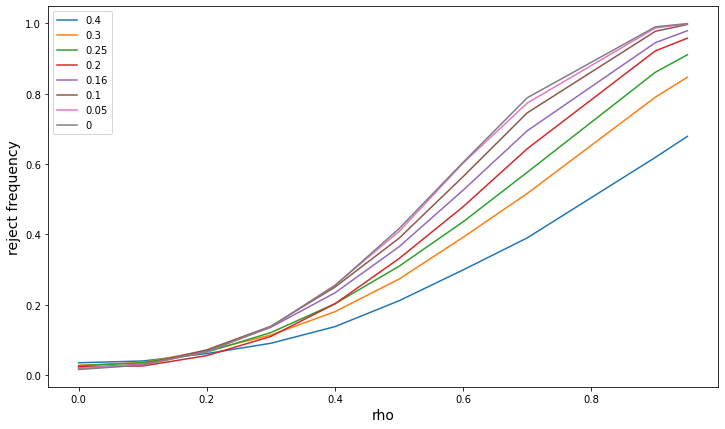

In [8]:
np.random.seed(123)
fig, ax = plt.subplots(figsize=(12, 7))
for a in a_range:
    t_table=np.zeros((S,10))
    pi=a*pii
    for s in range(S):
        V = np.random.normal(size=100)
        q = np.random.normal(size=100)
        for (i,rho) in enumerate(rho_range): 
            eps = V*rho+q*np.sqrt(1-rho**2)
            X = (Z@pi + V).reshape(-1,1)
            Y = X*np.array([0]) + eps.reshape(-1,1)
            pi_fd=OLS(X,Z)
            Xhat = Z@pi_fd
            beta_2sls = OLS(Y,Xhat)
            res = Y - X@beta_2sls
            s2_2sls = (res.T@res)/(N-1)
            SE_2sls = np.sqrt(s2_2sls * np.linalg.inv(Xhat.T@Xhat))
            tstat = beta_2sls / SE_2sls
            rej =  abs(tstat)>1.96
            t_table[s,i] = rej
    rejfreq= np.mean(t_table,axis=0)
    ax.plot(rho_range,rejfreq,label=a)
    ax.legend()
ax.set_xlabel("rho", size=14)
ax.set_ylabel("reject frequency", size=14);

When the correlation between the endogenous variable and the error term is zero(ρ = 0), there is
no endogeny, and all the rejection frequencies are close to 0.05;
However, as the correlation between the endogenous variable and the error term increases( ρ
increases), all the rejection frequencies have the same increasing pattern, which means its rejection
frequency under the null hypothesis no longer coincides with the significance level so it is unreliable.
With the decrease in the strength of the instrument, the t-statistic also increases, leading to an
increase in the rejection frequency. It means depending on the value of the other parameters in
the model, rejection frequency can take more or less any value between zero and one.


rho=0时，没有endogeneity，rejfreq都接近0.05，随着rho增加，rejfreq呈现相同的pattern，都是增加的，并且a=0.4最大的时候，size distortion最小

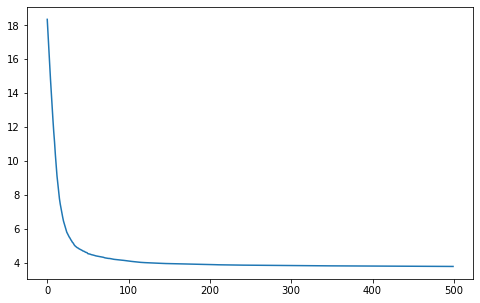

In [94]:
rg = np.arange(0,500,1)
LRs=np.zeros((S,len(rg)))
CV2=np.zeros(len(rg))
np.random.seed(123)
chi_1 = np.random.chisquare(df=1,size=S)
chi_9 = np.random.chisquare(df=9,size=S)
for g in range(len(rg)):
    for s in range(S):
        LRs[s,g] = (chi_9[s] + chi_1[s] - rg[g] +np.sqrt((chi_9[s] +chi_1[s] + rg[g])**2 - 4*rg[g]*chi_9[s])) / 2
    CV2[g]=np.quantile(LRs[:,g],0.95)
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(rg,CV2)

When r(β0)=0, the 95% critical value of LR statistic is equal to the 95% critical value of a χ
2
(9)
distributed random variable; When r(β0) is large, the 95% critical value of LR statistic is equal to
the 95% critical value of a χ
2
(1) distributed random variable.

In [35]:
CV[0]

18.351824548260034

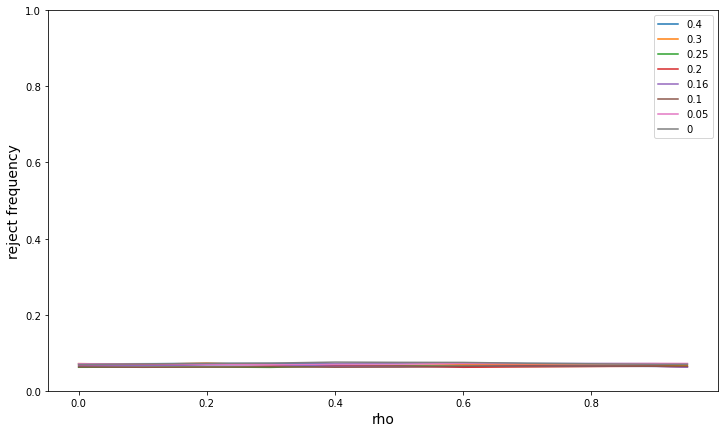

In [7]:
#AR test
np.random.seed(123)
fig, ax = plt.subplots(figsize=(12, 7))
k=10
for a in a_range:
    AR_table=np.zeros((S,10))
    pi=a*pii
    for s in range(S):    
        p = np.random.normal(size=100).reshape(-1,1)
        q = np.random.normal(size=100).reshape(-1,1)
        for (i,rho) in enumerate(rho_range):          
            V_eps=np.concatenate((p,q),axis=1) @ np.array([[1,0],[rho,np.sqrt(1-rho**2)]])
            eps=V_eps[:,0].reshape(-1,1)
            V=V_eps[:,1]
            #eps = V*rho+q*np.sqrt(1-rho**2)
            Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
            Mz=np.identity(N)-Pz
            AR=((eps.T@Pz@eps)*(N-k)) / ((eps.T@Mz@eps)*k)
            cv=stats.chi2.ppf(0.95, df=k) / k
            rej =  AR>cv
            AR_table[s,i] = rej
    rejfreq= np.mean(AR_table,axis=0)
    ax.plot(rho_range,rejfreq,label=a)
    ax.legend()
ax.set_ylim(ymin = 0, ymax = 1)
ax.set_xlabel("rho", size=14)
ax.set_ylabel("reject frequency", size=14);

the statistic is weak identification robust, is uncorelated with pi.不同的a对应不同的strength of instrument，但是没有pattern，他就是在0.05周围随机的


Text(0, 0.5, 'reject frequency')

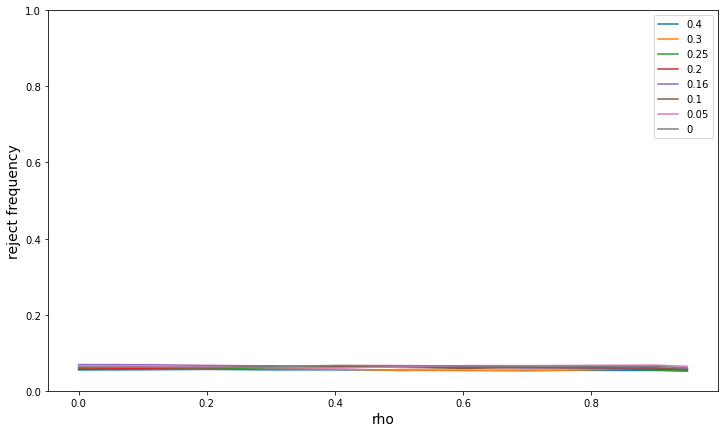

In [27]:
#LM test
np.random.seed(123)
fig, ax = plt.subplots(figsize=(12, 7))
for a in a_range:
    lm_table=np.zeros((S,10))
    pi=a*pii
    for s in range(S):
        V = np.random.normal(size=100)
        q = np.random.normal(size=100)
        for (i,rho) in enumerate(rho_range): 
            eps = (V*rho+q*np.sqrt(1-rho**2)).reshape(-1,1)
            X = (Z@pi + V).reshape(-1,1)
            Y = X*np.array([0]) + eps
            Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
            Mz=np.identity(N)-Pz
            sigma1hat=(eps.T @ Mz @ eps)/(N-k)
            sigma2hat=(eps.T @  Mz @ X) / (N-k)
            rho_hat=sigma2hat / sigma1hat
            pi_til=OLS(X-eps*rho_hat,Z)
            zpi=Z @ pi_til
            Pzpi= zpi@ np.linalg.inv(zpi.T@zpi)@zpi.T
            LM=eps.T @ Pzpi @ eps / sigma1hat
            cv=stats.chi2.ppf(0.95, df=1)
            rej =  (LM>cv)
            lm_table[s,i] = rej
    rejfreq= np.mean(lm_table,axis=0)
    ax.plot(rho_range,rejfreq,label=a)
    ax.legend()

ax.set_ylim(ymin = 0, ymax = 1)
ax.set_xlabel("rho", size=14)
ax.set_ylabel("reject frequency", size=14)

Text(0, 0.5, 'reject frequency')

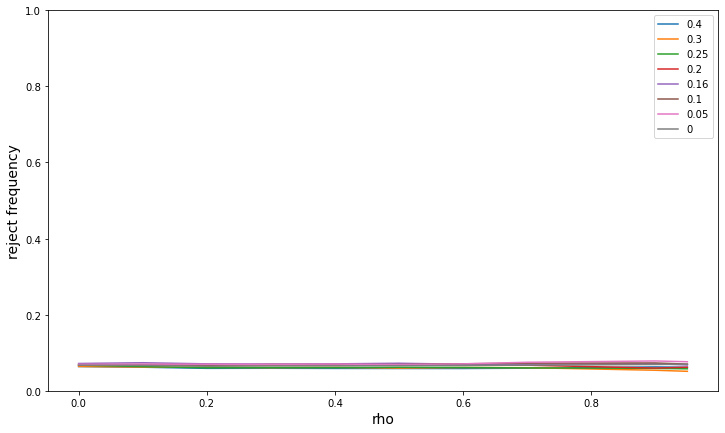

In [136]:
#LR test
np.random.seed(123)
fig, ax = plt.subplots(figsize=(12, 7))
for a in a_range:
    lr_table=np.zeros((S,10))
    pi=a*pii
    for s in range(S):
        V = np.random.normal(size=100)
        q = np.random.normal(size=100)
        for (i,rho) in enumerate(rho_range): 
            eps = (V*rho+q*np.sqrt(1-rho**2)).reshape(-1,1)
            X = (Z@pi + V).reshape(-1,1)
            Y = X*np.array([0]) + eps
            Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
            Mz=np.identity(N)-Pz
            sigma1hat=(eps.T @ Mz @ eps)/(N-k)
            sigma2hat=(eps.T @  Mz @ X) / (N-k)
            sigma4hat= (X.T @ Mz @ X) / (N-k)
            sigma4_epshat = sigma4hat  - sigma2hat**2 / sigma1hat
            rho_hat=sigma2hat / sigma1hat
            pi_til=OLS(X-eps*rho_hat,Z)
            zpi=Z @ pi_til
            Pzpi= zpi@ np.linalg.inv(zpi.T@zpi)@zpi.T
            
            kAR=eps.T@Pz@eps / sigma1hat
            r= pi_til.T @ Z.T @Z @ pi_til/sigma4_epshat
            lm=eps.T @ Pzpi @ eps / sigma1hat
            
            LR=(kAR - r + np.sqrt((kAR+r)**2 - 4*r*(kAR-lm)))/2
            
            cv=CV2[round(r[0][0])]
            rej =  (LR>cv)
            lr_table[s,i] = rej
    
    rejfreq= np.mean(lr_table,axis=0)
    ax.plot(rho_range,rejfreq,label=a)
    ax.legend()

ax.set_ylim(ymin = 0, ymax = 1)
ax.set_xlabel("rho", size=14)
ax.set_ylabel("reject frequency", size=14)

With the changing pi, the rejection frequency remained relatively constant and they coincide with
the significance level(0.05) for all the 3 statistics we used. Because the limit distribution of these
statistics does not depend on pi, these statistics are always size-correct.

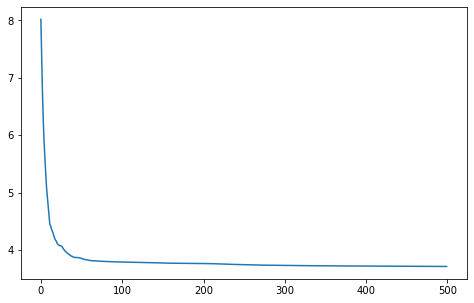

In [13]:
rg = np.arange(0,500,1)
LRs=np.zeros((S,len(rg)))
CV=np.zeros(len(rg))
np.random.seed(123)
chi_1 = np.random.chisquare(df=1,size=S)
chi_2 = np.random.chisquare(df=2,size=S)
for g in range(len(rg)):
    for s in range(S):
        LRs[s,g] = (chi_2[s] + chi_1[s] - rg[g] +np.sqrt((chi_2[s] +chi_1[s] + rg[g])**2 - 4*rg[g]*chi_2[s])) / 2
    CV[g]=np.quantile(LRs[:,g],0.95)
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(rg,CV)

In [3]:
import pandas as pd
df=pd.read_csv('C:\\Users\\Administrator\\Desktop\\AED2\\week2\\assignmentweakinstruments.csv')
df.describe()

,age,age2,ed,exper,exper2,nearc2,nearc4,nearc4a,nearc4b,race,smsa,south,wage
count,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000
mean,28.119601,800.549502,13.263455,8.856146,95.579070,0.440864,0.682060,0.492691,0.189321,0.233555,0.712957,0.403654,6.261832
std,3.137004,180.748395,2.676913,4.141672,84.618314,0.496573,0.465753,0.500030,0.391850,0.423162,0.452457,0.490711,0.443798
min,24.000000,576.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008964,0.000000,0.000000,0.000000,4.605170
25%,25.000000,625.000000,12.000000,6.000000,36.000000,0.000000,0.000000,0.000000,-0.001166,0.000000,0.000000,0.000000,5.976985
50%,28.000000,784.000000,13.000000,8.000000,64.000000,0.000000,1.000000,0.000000,0.000736,0.000000,1.000000,0.000000,6.286928
75%,31.000000,961.000000,16.000000,11.000000,121.000000,1.000000,1.000000,1.000000,0.003363,0.000000,1.000000,1.000000,6.563503
max,34.000000,1156.000000,18.000000,23.000000,529.000000,1.000000,1.000000,1.000000,1.009013,1.000000,1.000000,1.000000,7.784889


a

In [14]:
ystar=df['wage'].to_numpy().reshape(-1, 1) 
Xstar=df['ed'].to_numpy().reshape(-1, 1) 
Zstar=df['nearc2'].to_numpy().reshape(-1, 1) 
W=df[['exper','exper2','south','smsa','race']].to_numpy()
N,k=Zstar.shape
W=np.column_stack((np.ones((N,1)),W))

In [15]:
def drop_star(X,W):
     return X-W@OLS(X,W)

In [16]:
X=drop_star(Xstar,W)
Z=drop_star(Zstar,W)
y=drop_star(ystar,W)

In [17]:
def calculate_beta2sls(y,X,Z):
    pi=OLS(X,Z)
    V_hat=X-Z@pi
    X_hat=Z@pi
    beta_2sls=OLS(y,X_hat)
    res_2sls=y-X@beta_2sls
    s2_2sls=(res_2sls.T@res_2sls)/(N-1)
    SE_2sls=np.sqrt(s2_2sls*np.linalg.inv(X_hat.T@X_hat))
    #t_2sls=(beta_2sls-beta0) / SE_2sls
    return beta_2sls,SE_2sls

In [18]:
def calculate_AR(y,X,Z,beta0):
    Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
    Mz=np.identity(N)-Pz
    AR=(((y-X*beta0).T@Pz@(y-X*beta0))*(N-k)) / (((y-X*beta0).T@Mz@(y-X*beta0))*k)
    return AR

In [19]:
beta0_grid=np.arange(-3,3,0.1)
ARs=np.zeros(len(beta0_grid))
for (i,beta0) in enumerate(beta0_grid):
    ARs[i]=calculate_AR(y,X,Z,beta0)

Text(0, 0.5, 'AR statistic')

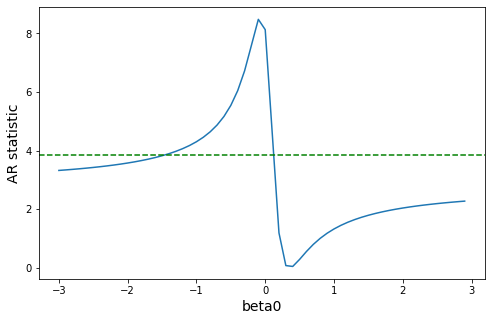

In [21]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,ARs)
cv_ar=stats.chi2.ppf(0.95, df=k) / k
ax.axhline(cv_ar,linestyle='--',color='green')
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("AR statistic", size=14)

In [22]:
#find confidence set of AR
beta0_lower=min(beta0_grid[ARs>cv_ar])
beta0_upper=max(beta0_grid[ARs>cv_ar])
print(beta0_lower)
print(beta0_upper)

-1.3999999999999986
0.10000000000000275


In [84]:
#find confidence set of t_2sls
cv_t=stats.t.ppf(0.975,N-k)
beta_2sls,SE_2sls=calculate_beta2sls(y,X,Z)
beta0_lower=beta_2sls-SE_2sls*cv_t
beta0_upper=beta_2sls+SE_2sls*cv_t
print(beta0_lower)
print(beta0_upper)

[[-0.04348185]]
[[0.74300902]]


c

In [85]:
pi=OLS(X,Z)
Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
Mz=np.identity(N)-Pz
sigma_vv=X.T@Mz@X / (N-k)
F=pi.T@Z.T@Z@pi/(sigma_vv*k)
F

array([[2.81046358]])

The value of F statistic is small so we cannot reject the null, it means Z is a weak instrument

In [31]:
#based on zz, calculate F
pi=OLS(X,ZZ)
Pz=ZZ @ np.linalg.inv(ZZ.T@ZZ)@ZZ.T
Mz=np.identity(N)-Pz
sigma_vv=X.T@Mz@X / (N-k)
F=pi.T@ZZ.T@ZZ@pi/(sigma_vv*k)
F

array([[27.90064132]])

In [43]:
#calculate the value of the AR statistic when the tested parameter is large
beta00_grid=np.arange(950,1000,1)
ARs=np.zeros(len(beta00_grid))
for (i,beta0) in enumerate(beta00_grid):
    ARs[i]=calculate_AR(y,X,Z,beta0)
ARs[-1]

2.8089105768003426

when the regressor X has only one variable, and when beta0 is very large, the value of AR statistic is stable around 2.81, which is the same value of the first stage F-statistic.

e

In [49]:
ZZstar=df[['nearc2','nearc4','nearc4a']].to_numpy()
N,K=ZZstar.shape
ZZ=drop_star(ZZstar,W)
beta0_grid=np.arange(-3,3,0.01)

In [30]:
#confidence set of t_2sls
beta_2sls,SE_2sls=calculate_beta2sls(y,X,ZZ)
cv_t=stats.t.ppf(0.975,N-K)
beta0_lower=beta_2sls-SE_2sls*cv_t
beta0_upper=beta_2sls+SE_2sls*cv_t
print(beta0_lower)
print(beta0_upper)

[[0.09074324]]
[[0.25124257]]


In [44]:
cv_ar=stats.chi2.ppf(0.95, df=K) / K
cv_ar

2.6049093010837265

Text(0, 0.5, 'AR statistic')

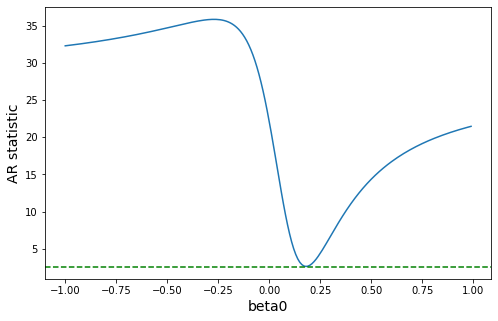

In [59]:
#confidence set of AR
beta0_grid=np.arange(-1,1,0.01)
ARs=np.zeros(len(beta0_grid))
for (i,beta0) in enumerate(beta0_grid):
    ARs[i]=calculate_AR(y,X,ZZ,beta0)

fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,ARs)
cv_ar=stats.chi2.ppf(0.95, df=K) / K
ax.axhline(cv_ar,linestyle='--',color='green')
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("AR statistic", size=14)

In [63]:
beta0_lower=min(beta0_grid[ARs<cv_ar])
beta0_upper=max(beta0_grid[ARs<cv_ar])
print(beta0_lower)
print(beta0_upper)

0.140000000000001
0.2300000000000011


In [60]:
Pz=ZZ @ np.linalg.inv(ZZ.T@ZZ)@ZZ.T
Mz=np.identity(N)-Pz
beta = np.arange(-2,2,0.01)
AR_beta = np.zeros(len(beta))
for i in range(len(beta)):
    AR_beta[i] = (((y-X*beta[i]).T @ Pz @ (y-X*beta[i]))/k)/(((y-X*beta[i]).T @ Mz @ (y-X*beta[i]))/(N-k))

Text(0, 0.5, 'AR statistic')

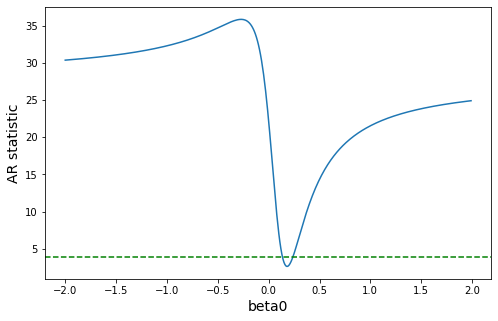

In [61]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta,AR_beta)
cv_ar=stats.chi2.ppf(0.95, df=k) / k
ax.axhline(cv_ar,linestyle='--',color='green')
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("AR statistic", size=14)

In [62]:
beta0_lower=min(beta[AR_beta<cv_ar])
beta0_upper=max(beta[AR_beta<cv_ar])
print(beta0_lower)
print(beta0_upper)

0.1400000000000019
0.2300000000000022


In [24]:
def calculate_LM_LR(y,X,Z,beta0):
    Pz=Z @ np.linalg.inv(Z.T@Z)@Z.T
    Mz=np.identity(N)-Pz
    eps=y-X*beta0
    sigma1hat=(eps.T @ Mz @ eps)/(N-k)
    sigma2hat=(eps.T @  Mz @ X) / (N-k)
    sigma4hat= (X.T @ Mz @ X) / (N-k)
    sigma4_epshat = sigma4hat  - sigma2hat**2 / sigma1hat
    rho_hat=sigma2hat / sigma1hat
    pi_til=OLS(X-eps*rho_hat,Z)
    zpi=Z @ pi_til
    Pzpi= zpi@ np.linalg.inv(zpi.T@zpi)@zpi.T

    kAR=eps.T@Pz@eps / sigma1hat
    r= pi_til.T @ Z.T @Z @ pi_til/sigma4_epshat
    LM=eps.T @ Pzpi @ eps / sigma1hat

    LR=(kAR - r + np.sqrt((kAR+r)**2 - 4*r*(kAR-LM)))/2
    
    return LM,LR,r

In [127]:
#confidence set of LM and LR
LMs=np.zeros(len(beta0_grid))
LRs=np.zeros(len(beta0_grid))
CVs_lr=np.zeros(len(beta0_grid))
for (i,beta0) in enumerate(beta0_grid):
    LMs[i],LRs[i],CVs_lr[i]=calculate_LM_LR(y,X,ZZ,beta0)
    CVs_lr[i]=CV[round(CVs_lr[i])]

Text(0, 0.5, 'LM statistic')

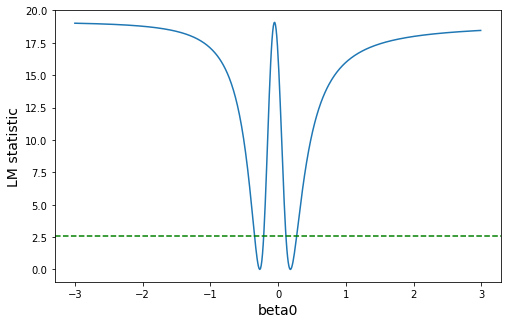

In [128]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,LMs)
cv_lm=stats.chi2.ppf(0.95, df=1)
ax.axhline(cv_ar,linestyle='--',color='green')
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("LM statistic", size=14)

In [129]:
beta0_l_l=min(beta0_grid[(beta0_grid<0)&(LMs<cv_lm)])
beta0_l_h=max(beta0_grid[(beta0_grid<0)&(LMs<cv_lm)])
beta0_r_l=min(beta0_grid[(beta0_grid>0)&(LMs<cv_lm)])
beta0_r_h=max(beta0_grid[(beta0_grid>0)&(LMs<cv_lm)])
print(beta0_l_l)
print(beta0_l_h)
print(beta0_r_l)
print(beta0_r_h)

-0.37000000000005606
-0.21000000000005947
0.1099999999999337
0.29999999999992966


Text(0, 0.5, 'LR statistic')

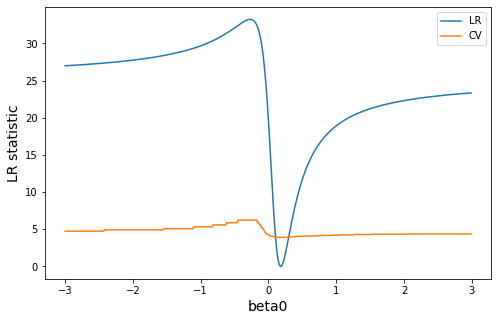

In [130]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,LRs,label='LR')
ax.plot(beta0_grid,CVs_lr,label='CV')
ax.legend()
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("LR statistic", size=14)

In [132]:
beta0_lower=min(beta0_grid[LRs<CVs_lr])
beta0_upper=max(beta0_grid[LRs<CVs_lr])
print(beta0_lower)
print(beta0_upper)

0.1099999999999337
0.28999999999992987


In [25]:
LMs=np.zeros(len(beta0_grid))
LRs=np.zeros(len(beta0_grid))
CVs_lr=np.zeros(len(beta0_grid))
for (i,beta0) in enumerate(beta0_grid):
    LMs[i],LRs[i],CVs_lr[i]=calculate_LM_LR(y,X,Z,beta0)
    CVs_lr[i]=CV[round(CVs_lr[i])]

Text(0, 0.5, 'LM statistic')

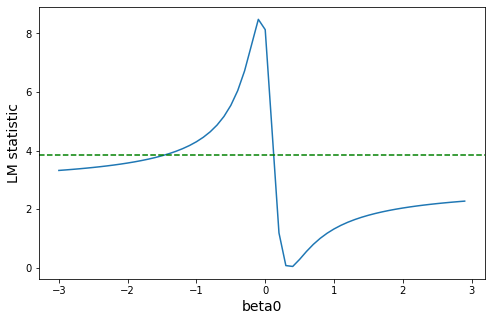

In [26]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,LMs)
cv_lm=stats.chi2.ppf(0.95, df=1)
ax.axhline(cv_ar,linestyle='--',color='green')
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("LM statistic", size=14)

Text(0, 0.5, 'LR statistic')

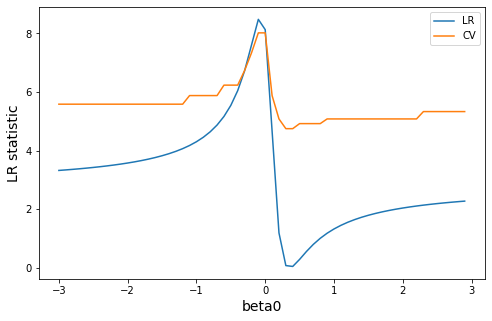

In [27]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(beta0_grid,LRs,label='LR')
ax.plot(beta0_grid,CVs_lr,label='CV')
ax.legend()
ax.set_xlabel("beta0", size=14)
ax.set_ylabel("LR statistic", size=14)